In order to run this notebook you have to install the package `trump` in your computer. In the root folder of `trump` package you can run:
```python
pip3 install -e .
```
to install as a developer mode or
```python
pip3 install .
```
If you want, you can also bootstrap the virtual environment and run your notebook inside the virtual environment.
```bash
bash bootstrap-python-env.sh
source trump-env/bin/activate
jupyter notebook
```
This package was developed to make feasible read the code in the notebook, write tests for the functions and also to have a more manageable code base.

In [1]:
import sys
import folium
import pandas as pd
import numpy as np
from datetime import datetime
from wordcloud import WordCloud 

from trump import load, treat, text

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

plots_args = {'fontsize': 14, 'color': '#9370DB'}

[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Demystifying POTUS, one tweet at a time...

Twitter plays a crucial role in politics these days. Gone are the days of door-to-door campaigning and trying to reach the last man. Today, power is weilded by those who can tweet. A carefully worded 140 character phrase carries the ability to swing states and potentially change the course of an entire nation. The goal of our project is to analyse the impact of Twitter on society and understand how ideas are spread across a network.

In order to investigate this question, our proposal is to analyse the tweets posted by Trump on Twitter over time to discover what was the main focus of his campaign, how it changed and how the society reacts to his discourses and proposals.

The Trump Twitter Archive is a project that has been collecting Trump's tweets since 2009 but the main focus of this project will be the period of his campaign.

**For the milestone we have the following topics to be addressed:**

- Choose the word scores dataset based on the amount of words available and context (what is the context upon which the scores were built).
- Discover the window time feasible to develop the project in a machine with 8GB of RAM. The period of campaign must be included in this interval.
- Descriptive and exploratory analysis of tweets' text.
- Clean stop words from dataset.
- Check if LDA model is a feasible approach to find topics and then classify tweets.
- Have a final proposal of the topics that will be analysed to answer the `Research Questions`

That will be answered in the next sections.

# Topics - Milestone 2

## Dataset partition
- Choose the word scores dataset based on the amount of words available and context (what is the context upon which the scores were built).
- Discover the window time feasible to develop the project in a machine with 8GB of RAM. The period of campaign must be included in this interval.


The amount of tweets is not so high as we expected, so it is feasible work with all the available years `{2009,...,2017}`. 

Be aware that the year of 2017 is not closed yet, so fields like `retweet_count` will mutate if you download the dataset in another instant of time. Beside that, the `as-of` of dataset in this repository of 2017 is `2017-11-24 14:00:00`.

In [2]:
df = load.load_tweets()

In [3]:
print('Dataset with {r} rows and size {s} MB \n'
      .format(r=len(df), s=round(sys.getsizeof(df)*1e-6, 1)))

HTML(df.head(2).T.to_html())

Dataset with 31224 rows and size 24.9 MB 



,1287,1288
id,881830110114009089,881697281233354753
created_at,2017-07-03 11:00:56,2017-07-03 02:13:07
favorite_count,69696,104824
lang,en,en
place.country,NaN,NaN
place.name,NaN,NaN
geo.coordinates,NaN,NaN
coordinates.coordinates,NaN,NaN
retweet_count,11325,25922
user.id,25073877,25073877


## Descriptive Analysis 
Descriptive and exploratory analysis of tweets' text.

### Number of tweets over time

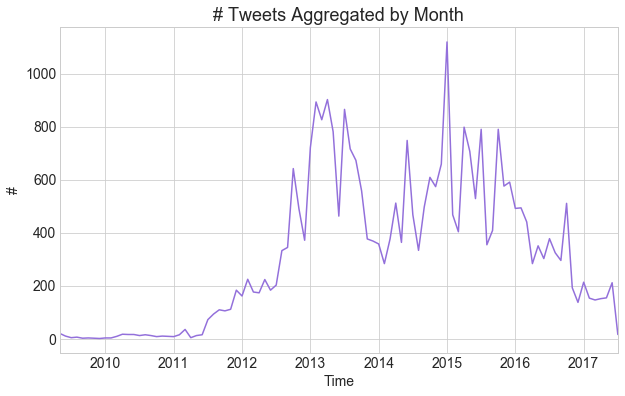

In [4]:
count_by_month = df.groupby('first_day_month_cohort').size()
count_by_month.plot(figsize=(10, 6), **plots_args);
plt.title('# Tweets Aggregated by Month', fontsize=18); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=14);

Trump annouced his campaign in middle of 2015 and there is no skip in the period.

### Missingness

In [5]:
def describe_missing(df):
    missing = []

    for c in df.columns:
        count_missing = pd.isnull(df[c]).sum()
        if count_missing > 0:
            missing.append((c, round(count_missing / df.shape[0], 2)))

    return pd.DataFrame(missing, columns=['col', 'missings']).set_index('col')

HTML(describe_missing(df).to_html())

,missings
col,
place.country,0.91
place.name,0.91
geo.coordinates,0.93
coordinates.coordinates,0.93


One of your research question is about geographic position, but seems that we won't be able to have a lot of accuracy and enough data to analyse. Let's check how `geo.coordinates` behaves over time.

### Device

This [blog post](http://varianceexplained.org/r/trump-tweets/) does an sentimental analysis of tweets split by device and it was found that certain types of devices tend to have more aggressive messages than others. Below we can see the number of tweets by device and quarter.

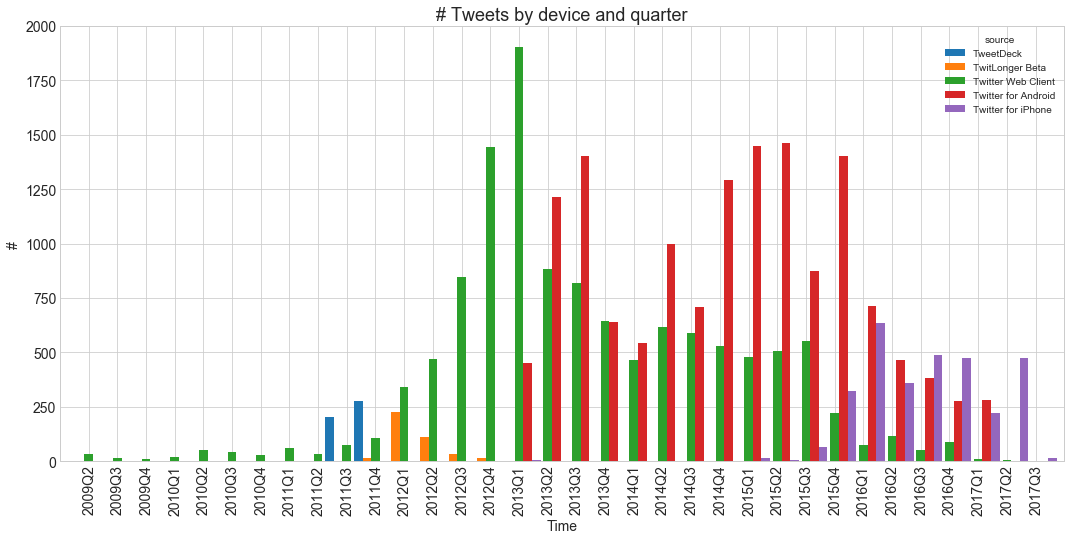

In [6]:
top_devices = (df.groupby('source').size()
               .sort_values(ascending=False)
               .iloc[0:5].index)
devices_over_time = (df[df['source'].apply(lambda x: x in top_devices)]
                     .groupby(['quarter_cohort', 'source'])
                     .size().unstack().fillna(0)
                     .plot(kind='bar', figsize=(18, 8), fontsize=14, width=1.5));
plt.title('# Tweets by device and quarter', fontsize=18); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=14);

From the chart above we can see that today Trump and his team uses mostly `iPhone` and `Android`. In the section [Clean and Analyse Text](#Clean-and-Analyse-Text) some analysis regarding the content of the tweet by device will be done.

### Weekday

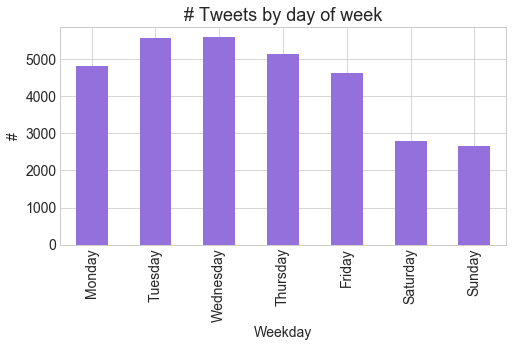

In [7]:
weekday = (pd.DataFrame(df.groupby(['weekday', 'weekday_number'])
                       .size()).reset_index()
           .sort_values('weekday_number')
           .set_index('weekday'))
del weekday['weekday_number'];
weekday.plot(kind='bar', figsize=(8, 4), legend=None, **plots_args);
plt.title('# Tweets by day of week', fontsize=18); 
plt.xlabel('Weekday', fontsize=14); plt.ylabel('#', fontsize=14);

As expected, the weekend is weaker than the others days but as we'll see in [Favorite](#Favorite) those are the best day to engage people

### Location

In section [Missingness](#Missingness) the variable `geo.coordinates` has a lot of missing values, however they are well spreaded over time, so it is still worth doing the analysis of geo location

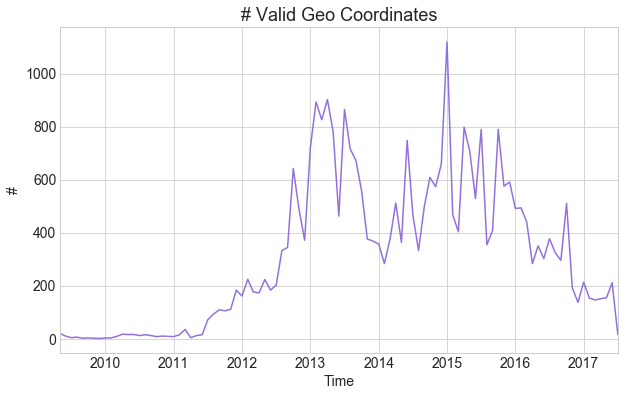

In [8]:
coord = df[['geo.coordinates', 'first_day_month_cohort']].copy()
coord['is_valid_coord'] = coord['geo.coordinates'].apply(lambda x: pd.notnull(str(x)))
coord_non_missing = coord.groupby('first_day_month_cohort').sum()

coord_non_missing.plot(figsize=(10, 6), legend=None, **plots_args);
plt.title('# Valid Geo Coordinates', fontsize=18); 
plt.xlabel('Time', fontsize=14); plt.ylabel('#', fontsize=14);

In [9]:
valid_geo = df[pd.notnull(df['geo.coordinates'])][['geo.coordinates', 'month_cohort', 'text']].values
m = folium.Map()

for tweet in valid_geo:
    folium.RegularPolygonMarker(tweet[0], 
                            popup=tweet[2],
                            fill_color='#45647d',
                            number_of_sides=4,
                            radius=1).add_to(m)
m.save('figures/map_tweets.html')

In [10]:
##################### Put link of the map here #####################
# Je crois que ça marché pas, je peux pas ouvrir le html #

The field `place.country` is calculated has the following distribution however is not that usefull because most of them are in United States

In [11]:
HTML(pd.DataFrame(pd.Series(df.groupby('place.country').size()).sort_values(ascending=False)).to_html())

,0
place.country,
United States,2784
United Kingdom,34
India,13
Ireland,9
Italy,7
Russia,3
Republic of Croatia,3
,3
Kingdom of Saudi Arabia,2


### Favorite
Based in the [twitter's documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) the field `favorite_count` is defined as the approximated how many times the tweet has been liked by twitter's users.

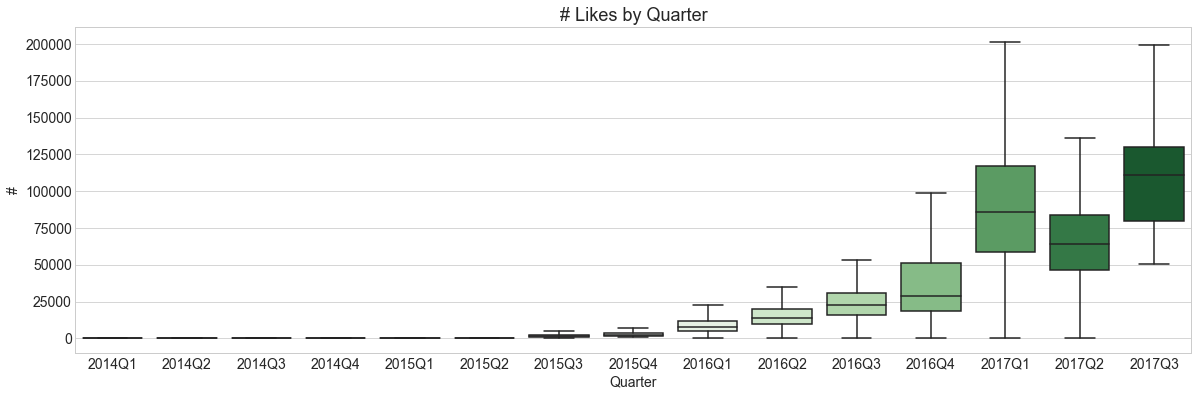

In [12]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='favorite_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Likes by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

Another hypotesis is if the tweets in the weekend have a better chances to be liked, because people are more available in the weekends

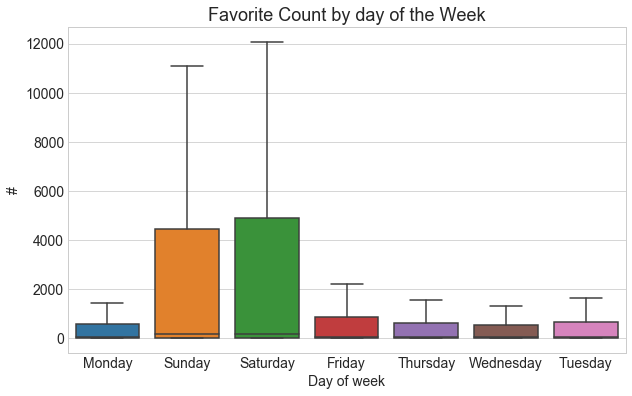

In [13]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='favorite_count', x='weekday', data=df, showfliers=False); # organize days
plt.title('Favorite Count by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

### Retweets

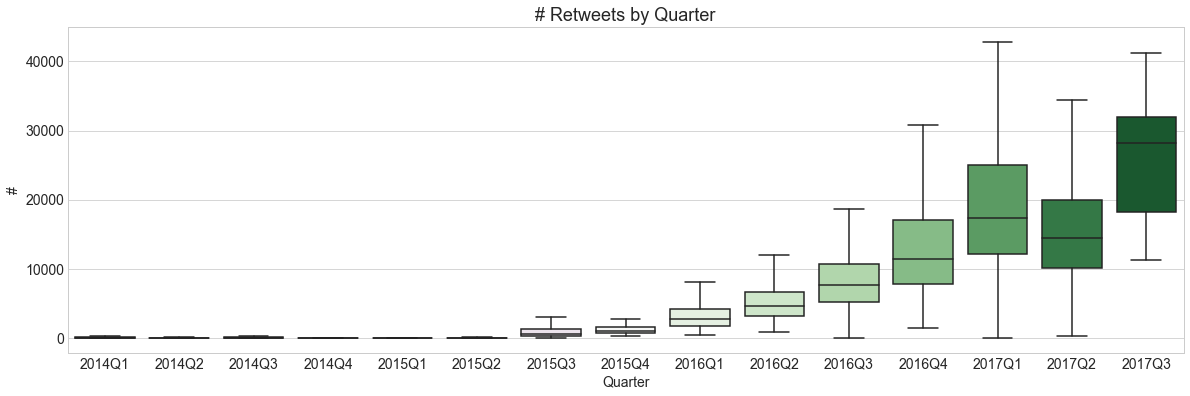

In [14]:
plt.figure(figsize=(20,6))
sns.boxplot(x='quarter_cohort', y='retweet_count',
            data=df[df['first_day_month_cohort'] > datetime(2014,1,1)].sort_values('first_day_month_cohort'), 
            showfliers=False, palette="PRGn");
plt.title('# Retweets by Quarter', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Quarter', fontsize=14); plt.ylabel('#', fontsize=14);

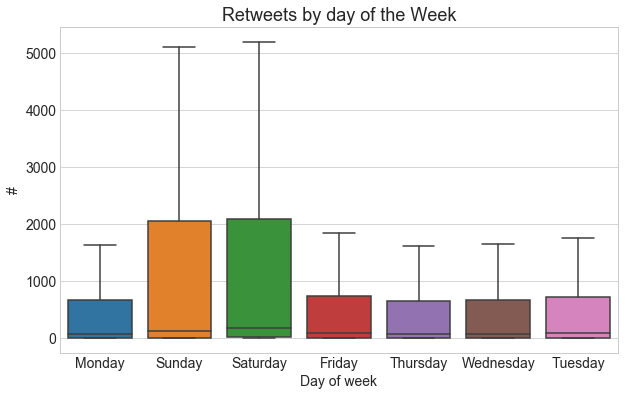

In [15]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y='retweet_count', x='weekday', data=df, showfliers=False); # organize days
plt.title('Retweets by day of the Week', fontsize=18);
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Day of week', fontsize=14); plt.ylabel('#', fontsize=14);

**It can be noted that the behavior of retweets is the same that the likes**

### Followers

The distribution of number of followers is very stable until middle of 2016, in the middle of 2016 the elections starts and it can be seen a spike. Another spike can be seen in the end of 2016 when he won the elections.

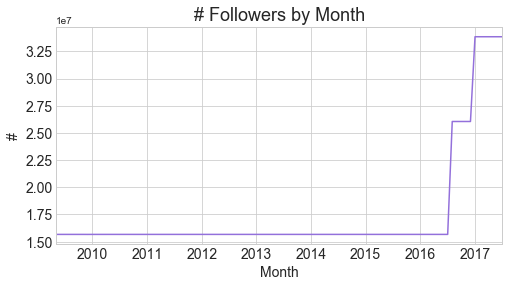

In [16]:
plt.figure(figsize=(8,4))
df.groupby('first_day_month_cohort').max()['user.followers_count'].plot(kind='line', **plots_args)
plt.title('# Followers by Month', fontsize=18); 
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel('Month', fontsize=14); plt.ylabel('#', fontsize=14);

In [17]:
####### This chart is a little bit weird, we might remove it #######

### Clean and Analyse Text
Clean stop words from dataset.

In [18]:
df['preprocessed_text'] = text.preprocessing_text(df['text'])
df['clean_text'] = text.remove_stop_words(df['preprocessed_text'])

After remove stop words, let's see what are the words that appear in hist tweets.

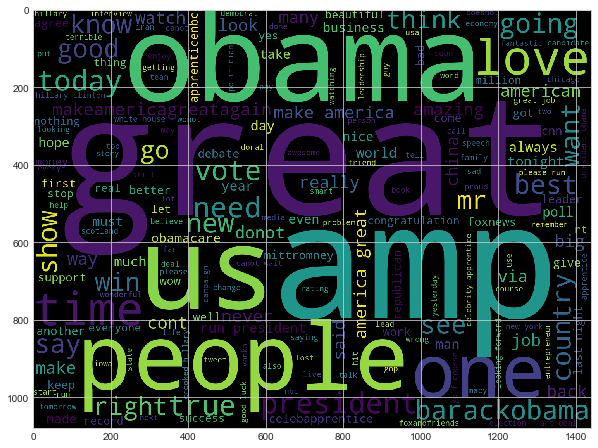

In [19]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
cloud = WordCloud(width=1440, height=1080).generate(' '.join(df['clean_text']));
ax.imshow(cloud);

Is this word count changing over time? Let's see how this is for every quarter.

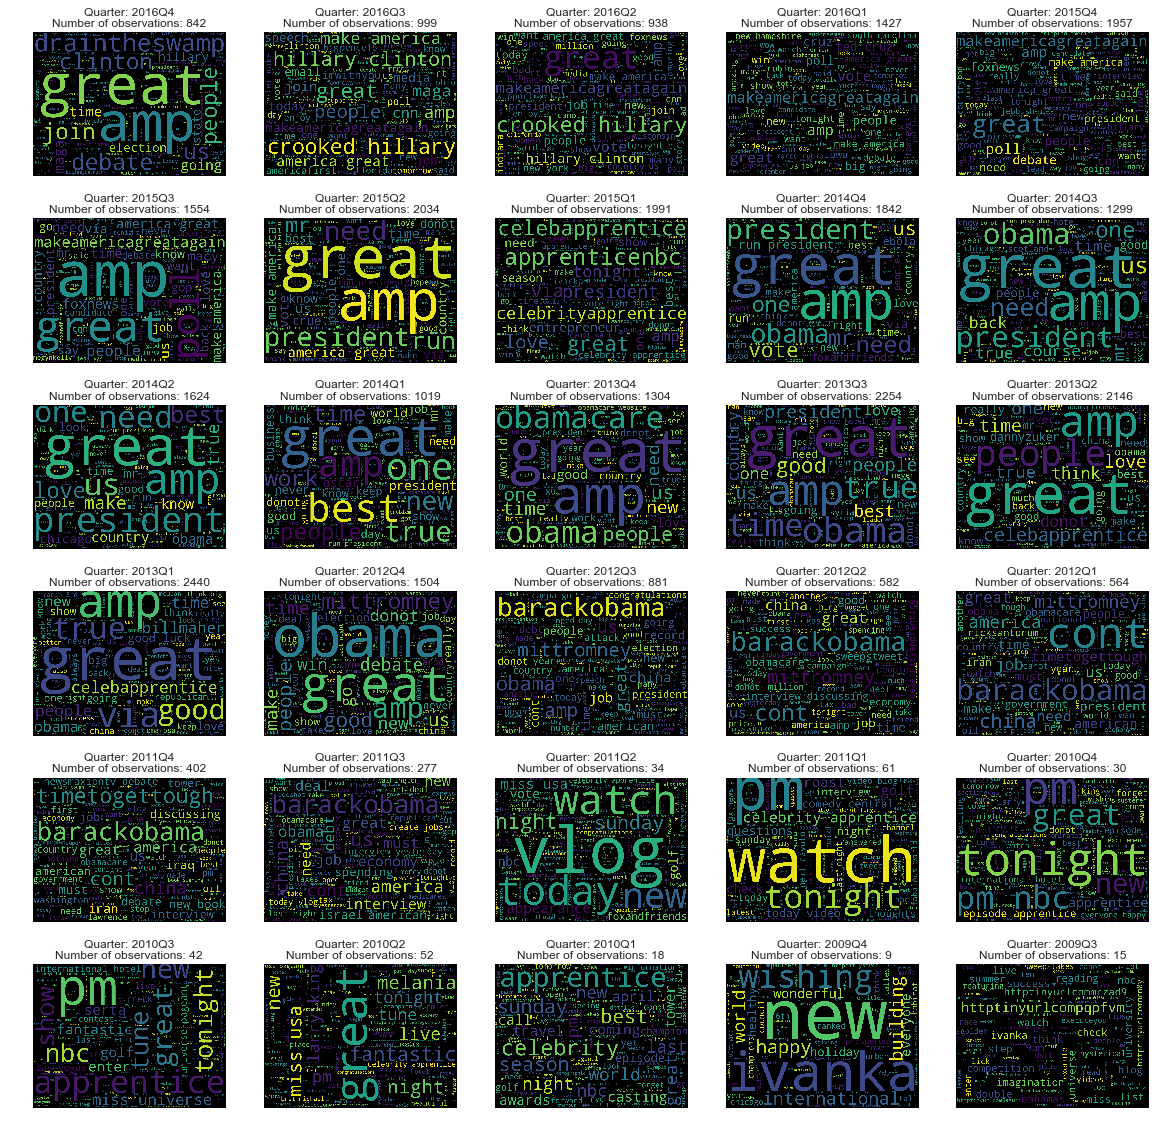

In [20]:
cohorts = df['quarter_cohort'].unique()[3:-1]

f, ax = plt.subplots(6, 5, figsize=(20, 20))
positions = np.array(range(30)).reshape(6, 5)
for num_c, c in enumerate(cohorts):
    pos = np.where(positions==num_c)
    
    tweets_cohort = df[df['quarter_cohort']==c]['clean_text']
    cloud = WordCloud(width=1440, height=1080).generate(' '.join(tweets_cohort));
    ax[pos[0][0], pos[1][0]].imshow(cloud);
    ax[pos[0][0], pos[1][0]].set_title('Quarter: {c}\nNumber of observations: {n}'.format(c=c, n=len(tweets_cohort)))
    ax[pos[0][0], pos[1][0]].axis('off')

### Topics classification
Check if LDA model is a feasible approach to find topics and then classify tweets.

In [ ]:
# TODO

### Research Questions
Have a final proposal of the topics that will be analysed to answer the `Research Questions`

In [13]:
# TODO